In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

In [2]:
# Read csv file, convert time to datetime data type
df = pd.read_csv('flex_networks.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], infer_datetime_format=True)

In [3]:
# Predictors are DoW and HoD
times = df['Timestamp']
DoW = []
HoD = []
MoY = []

for x in times:
    DoW.append(x.weekday())
    HoD.append(x.hour)
    MoY.append(x.month)

df['DoW'] = DoW
df['HoD'] = HoD
#df['MoY'] = MoY

In [4]:
targetColumns = list(df.columns[1:4]) + list(df.columns[5:19]) + list(df.columns[21:22])
for name in targetColumns:
    df[name + "_1day_pers"] = df[name].shift(48, axis=0)
    df[name + "_7day_pers"] = df[name].shift(336, axis=0)

In [5]:
predictorsAll = list(df.columns[23:])
df[predictorsAll] = df[predictorsAll]/df[predictorsAll].max()

mlpAll = []
data = np.empty((18,1440))
i = 0
for name in targetColumns:
    predictors = ['DoW', 'HoD', name + "_1day_pers", name + "_7day_pers", 'Air Temperature']
    targetColumn = name

    X = np.split(df[predictors].values, [336,7247,8687])
    y = np.split(df[targetColumn].values, [336,7247,8687])

    X_train = X[1]
    X_test = X[2]
    y_train = y[1]
    y_test = y[2]

    print("Training model ", i)
    mlp = MLPRegressor(hidden_layer_sizes=(5,5,5), activation='relu', solver='adam', max_iter=5000)
    mlp.fit(X_train,y_train)
    mlpAll.append(mlp)

    predict_test = mlp.predict(X_test)
    data[i] = predict_test
    i += 1



Training model  0
Training model  1
Training model  2
Training model  3
Training model  4
Training model  5
Training model  6
Training model  7
Training model  8
Training model  9
Training model  10
Training model  11
Training model  12
Training model  13
Training model  14
Training model  15
Training model  16
Training model  17


In [ ]:
for name in targetColumns:
    predict_test = mlp.predict(X_test)

In [72]:
targetColumns = "crawfordCrescent_F3"
df['crawford_pers_forecast'] = df['crawfordCrescent_F3'].shift(336, axis=0)
df['crawford_pers_forecast_1day'] = df['crawfordCrescent_F3'].shift(48, axis=0)
predictors = ['DoW', 'HoD', 'crawford_pers_forecast', 'crawford_pers_forecast_1day', 'Air Temperature']
df[predictors] = df[predictors]/df[predictors].max()

In [69]:
#5759
X = np.split(df[predictors].values, [336,7247,8687])
y = np.split(df[targetColumns].values, [336,7247,8687])

X_train = X[1]
X_test = X[2]
y_train = y[1]
y_test = y[2]

print(X_train.shape)
print(X_test.shape)

(6911, 4)
(1440, 4)


In [70]:
mlp = MLPRegressor(hidden_layer_sizes=(5,5,5), activation='relu', solver='adam', max_iter=5000)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

In [6]:
data2 = np.empty((18,30,48))
for feeder in range(data2.shape[0]):
    for day in range(data2.shape[1]):
        for hour in range(data2.shape[2]):
            data2[feeder][day][hour] = data[feeder][day*48 + hour]

data = np.asarray(data2)
#print(data.shape)

data_reshaped = data.reshape(data.shape[0], -1)

np.savetxt("forecastData.txt", data_reshaped)

load_data = np.loadtxt("forecastData.txt")
print(load_data.shape)
print(data.shape)
load_original_arr = load_data.reshape(load_data.shape[0], load_data.shape[1] // data.shape[2], data.shape[2])

print("shape of arr: ", data.shape)
print("shape of load_original_arr: ", load_original_arr.shape)

if (load_original_arr == data).all():
    print("Yes, both the arrays are same")
else:
    print("No, both the arrays are not same")


(18, 1440)
(18, 30, 48)
shape of arr:  (18, 30, 48)
shape of load_original_arr:  (18, 30, 48)
Yes, both the arrays are same


In [7]:
load = df[targetColumns].iloc[7247:8687].values
load = np.ravel(load)

realLoads = np.empty((18,30,48))
for day in range(realLoads.shape[1]):
    for hour in range(realLoads.shape[2]):
        for feeder in range(realLoads.shape[0]):
            realLoads[feeder][day][hour] = load[day*realLoads.shape[0]*realLoads.shape[2] + hour*realLoads.shape[0] + feeder]

In [24]:
y_true = df[targetColumns[1]].iloc[7247:8687]
x = data[0]
y_pred = np.ravel(data[1])
print("MAE: ", mean_absolute_error(y_true, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_true, y_pred))

MAE:  1.4572035997244537
MAPE:  0.24238185319717254


In [25]:
d = 6
l = d*48
h = d*48 + 3*48

# real_data = df["crawfordCrescent_F2"].iloc[7247:8687]
# predict_test = predict_test[:,1]
#preds = mlp.predict(df[predictors])


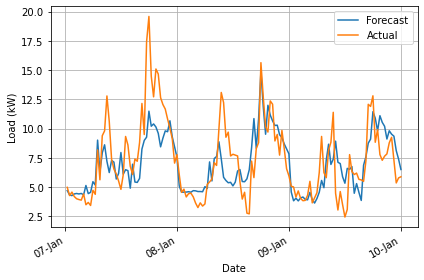

In [26]:
fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l:h], y_pred[l:h], label="Forecast")
ax.plot(df["Timestamp"].iloc[l:h], y_true[l:h], label="Actual")
# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel("Load (kW)")
ax.set_xlabel("Date")
ax.legend()

plt.tight_layout()
#plt.savefig("pers_forecast.jpg", dpi=300, bbox_inches="tight")
plt.show()

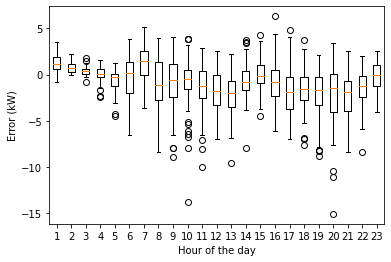

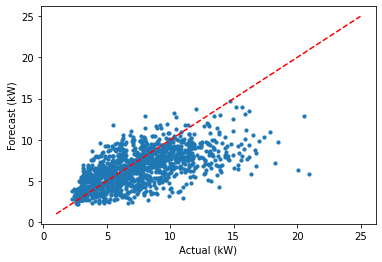

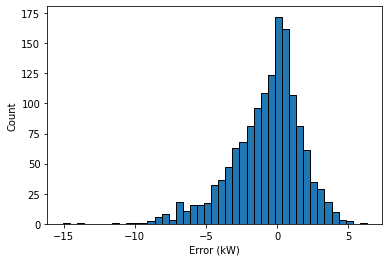

In [69]:
mean_absolute_error(real_data,predict_test)
error = predict_test - real_data
box_data =[]

for i in range(1,24):
    x = error.values[i*2::48]
    y = error.values[i*2-1::48]
    box_data.append(np.concatenate((x,y)))


plt.boxplot(box_data)
plt.xlabel("Hour of the day")
plt.ylabel("Error (kW)")
#plt.savefig("boxplot.jpg", dpi=300)
plt.show()

plt.scatter(real_data, predict_test,s=10)
plt.plot([1,25], [1,25], c="r",ls="--")
plt.xlabel("Actual (kW)")
plt.ylabel("Forecast (kW)")
#plt.savefig("linear.jpg", dpi=300)
plt.show()

plt.hist(error, bins='auto', edgecolor='black', linewidth=1)
plt.xlabel("Error (kW)")
plt.ylabel("Count")
#plt.savefig("hist.jpg", dpi=300)
plt.show()

In [70]:
peaksReal = []
peaksPred = []
dayLoadsReal = []
dayLoadsPred = []
hourOfPeakReal = []
hourOfPeakPred = []

n = 48

for i in range(0, len(real_data), n):
    dayReal = real_data[i:i + n]
    dayPred = predict_test[i:i + n]
    dayLoadsReal.append(dayReal)
    dayLoadsPred.append(dayPred)
    peakReal = max(dayReal)
    peakPred = max(dayPred)
    peaksReal.append(peakReal)
    peaksPred.append(peakPred)
    hourOfPeakReal.append(dayReal.argmax())
    hourOfPeakPred.append(dayPred.argmax())

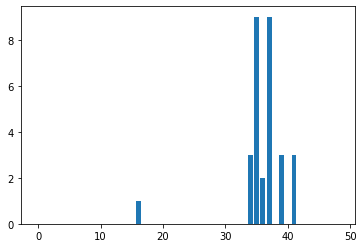

In [37]:
count = []

for i in range(49):
    count.append(hourOfPeakPred.count(i))

plt.bar(range(len(count)), count)
plt.show()

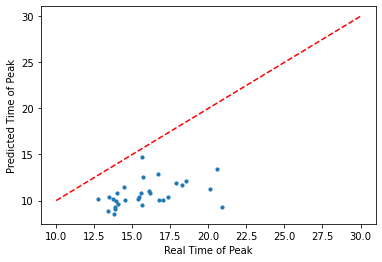

In [71]:
plt.scatter(peaksReal, peaksPred,s=10)
plt.plot([10,30], [10,30], c="r",ls="--")
plt.xlabel("Real Time of Peak")
plt.ylabel("Predicted Time of Peak")
#plt.savefig("linear.jpg", dpi=300)
plt.show()
